## Initialization

### Imports

In [1]:
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import (
    SparkSession, 
    functions as F,
    types as T,
)
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_percentage_error,
    r2_score,
)
from sklearn.model_selection import train_test_split

sys.path.append(str(pathlib.Path().absolute().parent))
from config import CAMPAIGN_PATH
from utils import get_spark_session, display_df

### Configs

In [2]:
START_CAMPAIGN_DATE = "2022-07-04"

DISPLAY = True

SPARK_THREADS = 6
SPARK_DRIVER_MEMORY = 6
SPARK_MAX_RESULT_SIZE = 4

### Spark

In [3]:
spark = get_spark_session(
    spark_threads=SPARK_THREADS,
    spark_driver_memory=SPARK_DRIVER_MEMORY,
    spark_max_result_size=SPARK_MAX_RESULT_SIZE,
)

23/10/25 22:40:08 WARN Utils: Your hostname, tapsi-UX430UNR resolves to a loopback address: 127.0.1.1; using 192.168.1.12 instead (on interface wlp2s0)
23/10/25 22:40:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/25 22:40:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data Preparation

### Read `campaign` Data

In [4]:
campaign_df = (
    spark.read.option("header", True).csv(CAMPAIGN_PATH)
    .select(
        F.col("date"),
        F.col("campaign").cast(T.LongType()).alias("campaign"),
        F.col("other").cast(T.FloatType()).alias("other"),
    )
    .orderBy("date")
)

display_df(campaign_df, display=DISPLAY)

root
 |-- date: string (nullable = true)
 |-- campaign: long (nullable = true)
 |-- other: float (nullable = true)

DataFrame size: 722
+----------+--------+------------+
|date      |campaign|other       |
+----------+--------+------------+
|2021-01-19|33678705|0.0015864404|
|2021-01-20|35581705|0.0015864404|
|2021-01-21|26748805|0.0015864404|
|2021-01-22|21457052|0.0015864404|
|2021-01-23|13294812|0.0015864404|
+----------+--------+------------+
only showing top 5 rows



### Seperate Before and After Running Campaign Data

In [5]:
before_campaign_df = (
    campaign_df
    .filter(F.col("date") < START_CAMPAIGN_DATE)
)

after_campaign_df = (
    campaign_df
    .filter(F.col("date") > START_CAMPAIGN_DATE)
)

### Insight

### Plot Campaign and Other Time-Series Scatter-Plot in Before Running Campaign Interval

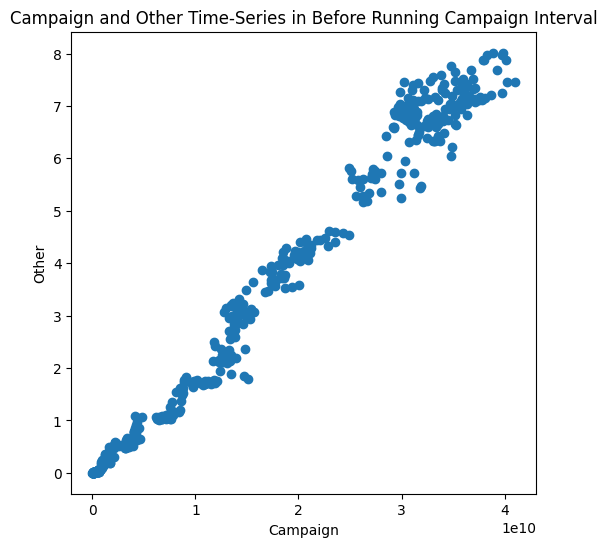

In [6]:
before_campaign_pdf = before_campaign_df.toPandas()

plt.figure(figsize=(6, 6))

plt.scatter(
    before_campaign_pdf["campaign"],
    before_campaign_pdf["other"],
)

plt.xlabel("Campaign", fontsize=10)
plt.ylabel("Other", fontsize=10)
plt.title(
    "Campaign and Other Time-Series in Before Running Campaign Interval",
    fontsize=12,
)
plt.show()

### Campaign and Other Time-Series Correlation in Before Running Campaign Interval

In [7]:
correlation = (
    before_campaign_df
    .corr(
        "campaign",
        "other"
    )
)

print(
    "Campaign and Other Time-Series Correlation for Before Running Campaign:",
    correlation,
)

Campaign and Other Time-Series Correlation for Before Running Campaign: 0.9919045049586948


### Result

According to the above results, before running campaign, we can assume that the value of campaign and other time-series have a linear relationship.

## Train Campaign-predictor model

### Split Train and Test data

In [8]:
X = np.array(before_campaign_pdf["other"]).reshape(-1, 1)
y = np.array(before_campaign_pdf["campaign"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True
)

### Train model

In [9]:
campaign_predictor = LinearRegression()

campaign_predictor.fit(X_train, y_train)

LinearRegression()

### Evaluate

In [10]:
predicted_y_test = campaign_predictor.predict(X_test)

print("R2 Score:", r2_score(y_test, predicted_y_test))
print(
    "Mean Absolute Percentage Error (MAPE):", 
    mean_absolute_percentage_error(y_test, predicted_y_test),
)

R2 Score: 0.9817735320806822
Mean Absolute Percentage Error (MAPE): 1.4331516974943046


## Evaluate Campaign Test

### Predict Campaign Time-Series for After Running Campaign

In [11]:
@F.udf(returnType=T.LongType())
def predict_campaign_value(other: float) -> float:
    return int(campaign_predictor.predict([[other]])[0])

after_campaign_with_predicted_campaign_value_df = (
    after_campaign_df
    .withColumn(
        "predictedCampaign",
        predict_campaign_value(F.col("other"))
    )
)

display_df(
    after_campaign_with_predicted_campaign_value_df,
    display=DISPLAY,
)

root
 |-- date: string (nullable = true)
 |-- campaign: long (nullable = true)
 |-- other: float (nullable = true)
 |-- predictedCampaign: long (nullable = true)

DataFrame size: 190


+----------+-----------+---------+-----------------+
|date      |campaign   |other    |predictedCampaign|
+----------+-----------+---------+-----------------+
|2022-07-05|35034844141|7.398393 |35735999875      |
|2022-07-06|36494135475|7.457347 |36015409995      |
|2022-07-07|37269628643|7.360912 |35558358002      |
|2022-07-08|36845938921|7.339254 |35455710631      |
|2022-07-09|35333930402|7.0541935|34104672813      |
+----------+-----------+---------+-----------------+
only showing top 5 rows



### Calculate Campaign Improvement per day

In [12]:
improvement = np.array(
    after_campaign_with_predicted_campaign_value_df
    .withColumn(
        "improvement",
        100 * (
            (F.col ("campaign") / F.col("predictedCampaign"))
            - 1
        ),
    )
    .toPandas()["improvement"]
)

#### Improvement Distribution

Max Daily Improvement: 35.1667194927856
Min Daily Improvement: -33.41249447923473


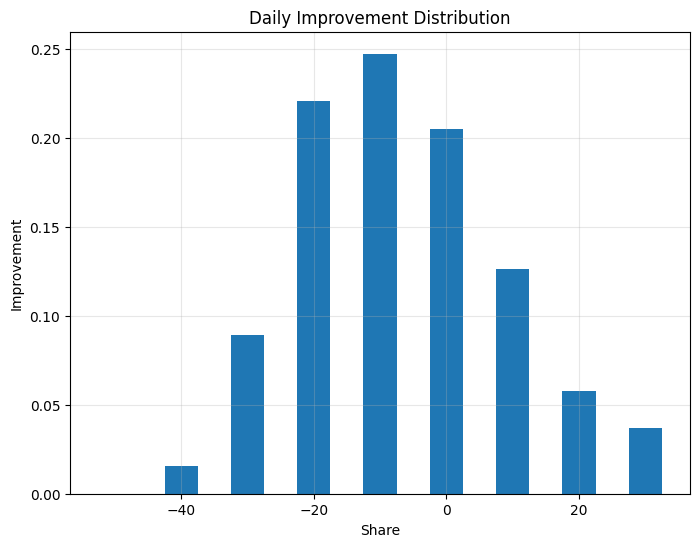

In [13]:
print("Max Daily Improvement:", max(improvement))
print("Min Daily Improvement:", min(improvement))

plt.figure(figsize=(8, 6))

plt.hist(
    improvement,
    bins=range(-50, 50, 10),
    weights=np.ones(len(improvement)) / len(improvement),
    rwidth=0.5,
    align="left",
)

plt.xlabel("Share", fontsize=10)
plt.ylabel("Improvement", fontsize=10)
plt.title("Daily Improvement Distribution", fontsize=12)
plt.grid(alpha=0.3)

plt.show()

According to the above results, considering that the improvement variable is continuous, normal and without outliers, the t test can be used.

### Has running of the Campaign affected Campaign?

In [14]:
stats.ttest_1samp(
    a=improvement,
    popmean=0,
)

TtestResult(statistic=-1.3858235802679275, pvalue=0.16743378482774426, df=189)

Considering that the p-value is not less than 5%, it cannot be said with certainty that the campaign had an impact on the time series of the campaign. We need more samples!